In [36]:
import os 
import random 
import torch
from torch.utils.data import Dataset
from typing import List, Optional


class ten_known_commands(Dataset):
    def __init__(
        self, base_dir, test_list_path=None, return_label_name=False, train=True,
        target_count_train=2100, target_count_test=250, silence_list=None
    ):
        self.filepaths = []
        self.labels = []
        self.return_label_name = return_label_name

        self.known_labels = [
            "no",
            "yes",
            "up",
            "down",
            "left",
            "right",
            "on",
            "off",
            "stop",
            "go",
        ]

        self.label_to_index = {
            label: idx for idx, label in enumerate(self.known_labels)
        }
        self.label_to_index["unknown"] = 10
        self.label_to_index["silence"] = 11
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}

        included_files = set()

        # Load filenames from testing_list.txt if provided
        if test_list_path and os.path.exists(test_list_path):
            with open(test_list_path, "r") as f:
                for line in f:
                    file_name = os.path.splitext(os.path.basename(line.strip()))[0] + ".pt"
                    included_files.add(file_name)

        all_folders = os.listdir(base_dir)

        # Temporary storages
        unknown_samples = []

        for label in all_folders:
            label_path = os.path.join(base_dir, label)

            if not os.path.isdir(label_path):
                continue

            if label == "silence":
                continue  # Silence is handled separately!

            if label in self.known_labels:
                assigned_label = label
            else:
                assigned_label = "unknown"

            for file in os.listdir(label_path):
                if file.endswith(".pt"):
                    file_base = os.path.splitext(file)[0] + ".pt"
                    is_included = file_base in included_files

                    if (train and not is_included) or (not train and is_included):
                        if assigned_label == "unknown":
                            unknown_samples.append(os.path.join(label_path, file))
                        else:
                            self.filepaths.append(os.path.join(label_path, file))
                            self.labels.append(self.label_to_index[assigned_label])

        # Handle unknown undersampling
        if train:
            if unknown_samples:
                undersampled_unknown = random.sample(unknown_samples, k=target_count_train)
                self.filepaths.extend(undersampled_unknown)
                self.labels.extend([self.label_to_index["unknown"]] * target_count_train)
        else:
            if unknown_samples:
                undersampled_unknown = random.sample(unknown_samples, k=target_count_test)
                self.filepaths.extend(undersampled_unknown)
                self.labels.extend([self.label_to_index["unknown"]] * target_count_test)

        # Handle silence separately
        
        if silence_list is not None:
            if train:
                print("train")
                oversampled_silence = random.choices(silence_list, k=target_count_train)
                self.filepaths.extend(oversampled_silence)
                self.labels.extend([self.label_to_index["silence"]] * target_count_train)
            else:
                print("test")
                oversampled_silence = random.choices(silence_list, k=target_count_test)
                self.filepaths.extend(oversampled_silence)
                self.labels.extend([self.label_to_index["silence"]] * target_count_test)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        spectrogram = torch.load(self.filepaths[idx])
        label_index = self.labels[idx]
        return spectrogram, (
            self.index_to_label[label_index] if self.return_label_name else label_index
        )


In [37]:
import os
import random
import torch
from torch.utils.data import DataLoader
from typing import List, Optional


def pad_collate(batch):
    specs, labels = zip(*batch)
    max_len = max(spec.shape[-1] for spec in specs)
    padded_specs = []

    for spec in specs:
        pad_len = max_len - spec.shape[-1]
        padded_spec = torch.nn.functional.pad(spec, (0, pad_len), value=0)
        padded_specs.append(padded_spec)

    return torch.stack(padded_specs), torch.tensor(labels)


base_path = "../data/processed/train/audio"
test_list_path = "../data/raw/train/testing_list.txt"

# Prepare silence train/test splits
import os
import random

silence_dir = "../data/processed/train/audio/silence"
all_silence_files = [
    os.path.join(silence_dir, file)
    for file in os.listdir(silence_dir)
    if file.endswith(".pt")
]

random.seed(42)  # For reproducibility
random.shuffle(all_silence_files)
split_idx = int(0.9 * len(all_silence_files))
train_silence_files = all_silence_files[:split_idx]
test_silence_files = all_silence_files[split_idx:]

# Instantiate your datasets
train_dataset = ten_known_commands(
    base_path,
    test_list_path=test_list_path,
    return_label_name=False,
    train=True,
    silence_list=train_silence_files,
)
test_dataset = ten_known_commands(
    base_path,
    test_list_path=test_list_path,
    return_label_name=False,
    train=False,
    silence_list=test_silence_files,
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate
)
test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate
)

train
test


In [38]:
from collections import Counter
import matplotlib.pyplot as plt

# Assuming train_dataset is already created
# If not, instantiate it first:
# train_dataset = ten_known_commands(base_path, test_list_path=test_list_path, return_label_name=True, train=True)

# Create a Counter to count labels
counter = Counter()

# Iterate over the dataset
s = 0
for _, label in test_dataset:
    s += 1
    if s % 1000 == 0:
        print(s)
    if isinstance(label, int):
        # If return_label_name=False, label is an int
        label = train_dataset.index_to_label[label]  # Get label name
    counter[label] += 1

# Print counts
print("Class counts:")
for label, count in counter.items():
    print(f"{label}: {count}")

C:\Users\cypri\AppData\Local\Temp\ipykernel_130032\4173280733.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram = torch.load(self.filepaths[idx])


1000
2000
3000
Class counts:
down: 253
go: 251
left: 267
no: 252
off: 262
on: 246
right: 259
stop: 249
up: 272
yes: 256
unknown: 250
silence: 250


In [39]:
class EarlyStopper:
    def __init__(self, patience=2, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.best_epoch = -1

    def should_stop(self, score, epoch):
        if self.best_score is None or score > self.best_score + self.min_delta:
            self.best_score = score
            self.best_epoch = epoch
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience




In [40]:

config = {
    "experiment_name": "speech-commands-10known-commands",
    "run_name": "cnn-rnn-v1",
    
    "registered_model_name": "10knonwcommandsClassifier",
    "num_epochs": 15,
    "learning_rate": 0.001,
    "batch_size": 32,
}


In [41]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))



from mlflow_tracking.tracking_utils import (
    mlflow_run,
    log_metrics,
    log_learning_curves,
    log_confusion_matrix,
    log_checkpoint_model,
)

In [42]:
from models import CNNRNNClassifierDropout
import torch.optim.lr_scheduler as lr_scheduler
import time 

@mlflow_run(config)
def train_v2():
    model = CNNRNNClassifierDropout(
    num_classes=12, input_freq_bins=128
)  

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(), lr=config["learning_rate"], weight_decay=1e-4
    )
    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=3, factor=0.5, verbose=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    early_stopper = EarlyStopper(patience=5, min_delta=0.001)
    best_model_path = None
    
    
    for epoch in range(config["num_epochs"]):
        print("Epoch:", epoch + 1)
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()
        compteur = 0
        
        for X, y in train_loader:
            if compteur % 50 == 0:
                print("Batch:", compteur)
            compteur += 1
            X, y = X.to(device), torch.tensor(y).to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(y).sum().item()
            total += y.size(0)

        avg_loss = running_loss / len(train_loader)
        train_acc = correct / total
        elapsed_time = time.time() - start_time

        model.eval()

        with torch.no_grad():
            test_correct = 0
            test_total = 0
            test_running_loss = 0.0
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                out = model(X_test)
                loss = criterion(out, y_test)
                test_running_loss += loss.item()
                pred = out.argmax(dim=1)
                test_correct += pred.eq(y_test).sum().item()
                test_total += y_test.size(0)
        test_acc = test_correct / test_total
        test_loss = test_running_loss / len(test_loader)

        test_losses.append(test_loss)
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        log_metrics(
            {
                "loss": avg_loss,
                "test_loss": test_loss,
                "accuracy": train_acc,
                "test_accuracy": test_acc,
                "epoch_time_sec": elapsed_time,
                "current_lr": optimizer.param_groups[0]["lr"],
            },
            step=epoch,
        )

        print(f"Epoch {epoch+1}/{config['num_epochs']}, Time: {elapsed_time:.2f}s")
        print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

        best_model_path = log_checkpoint_model(model, epoch)

        # ✨ Step the scheduler on test_acc (maximize mode)
        scheduler.step(test_acc)

        # ⏹️ Early stopping
        if early_stopper.should_stop(test_acc, epoch):
            print(
                f"Early stopping at epoch {epoch+1} — no improvement for {early_stopper.patience} epochs."
            )
            break

    # 📈 Plot learning curves
    log_learning_curves(
        train_metrics={"loss": train_losses, "accuracy": train_accuracies},
        val_metrics={"loss": test_losses, "accuracy": test_accuracies},
    )

    return {"model": model, "best_model_path": best_model_path}

In [43]:
train_v2()

c:\Users\cypri\anaconda3\envs\Torch_Intro_ML\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\cypri\AppData\Local\Temp\ipykernel_130032\4173280733.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True

Epoch: 1
Batch: 0
Batch: 50
Batch: 100
Batch: 150
Batch: 200
Batch: 250
Batch: 300
Batch: 350
Batch: 400
Batch: 450
Batch: 500
Batch: 550
Batch: 600
Batch: 650
Batch: 700
Batch: 750
Batch: 800
Batch: 850
Batch: 900
Batch: 950
Batch: 1000
Batch: 1050
Batch: 1100
Batch: 1150
Batch: 1200
Batch: 1250
Batch: 1300
Batch: 1350
Batch: 1400
Batch: 1450
Batch: 1500
Batch: 1550
Epoch 1/15, Time: 312.42s
Train Acc: 0.4954, Test Acc: 0.6710
Epoch: 2
Batch: 0
Batch: 50
Batch: 100
Batch: 150
Batch: 200
Batch: 250
Batch: 300
Batch: 350
Batch: 400
Batch: 450
Batch: 500
Batch: 550
Batch: 600
Batch: 650
Batch: 700
Batch: 750
Batch: 800
Batch: 850
Batch: 900
Batch: 950
Batch: 1000
Batch: 1050
Batch: 1100
Batch: 1150
Batch: 1200
Batch: 1250
Batch: 1300
Batch: 1350
Batch: 1400
Batch: 1450
Batch: 1500
Batch: 1550
Epoch 2/15, Time: 226.32s
Train Acc: 0.7186, Test Acc: 0.7757
Epoch: 3
Batch: 0
Batch: 50
Batch: 100
Batch: 150
Batch: 200
Batch: 250
Batch: 300
Batch: 350
Batch: 400
Batch: 450
Batch: 500
Batch: 55

2025/04/28 01:01:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model '10knonwcommandsClassifier'.
Created version '1' of model '10knonwcommandsClassifier'.


{'model': CNNRNNClassifierDropout(
   (cnn): Sequential(
     (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
     (4): Dropout2d(p=0.2, inplace=False)
     (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): ReLU()
     (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
     (9): Dropout2d(p=0.2, inplace=False)
   )
   (rnn): GRU(2048, 128, batch_first=True, bidirectional=True)
   (dropout_rnn_out): Dropout(p=0.3, inplace=False)
   (classifier): Sequential(
     (0): Linear(in_features=256, out_features=128, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.3, inplace=False)
     (3): Linear(in_features=128, o

C:\Users\cypri\AppData\Local\Temp\ipykernel_130032\3566104911.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\cyp

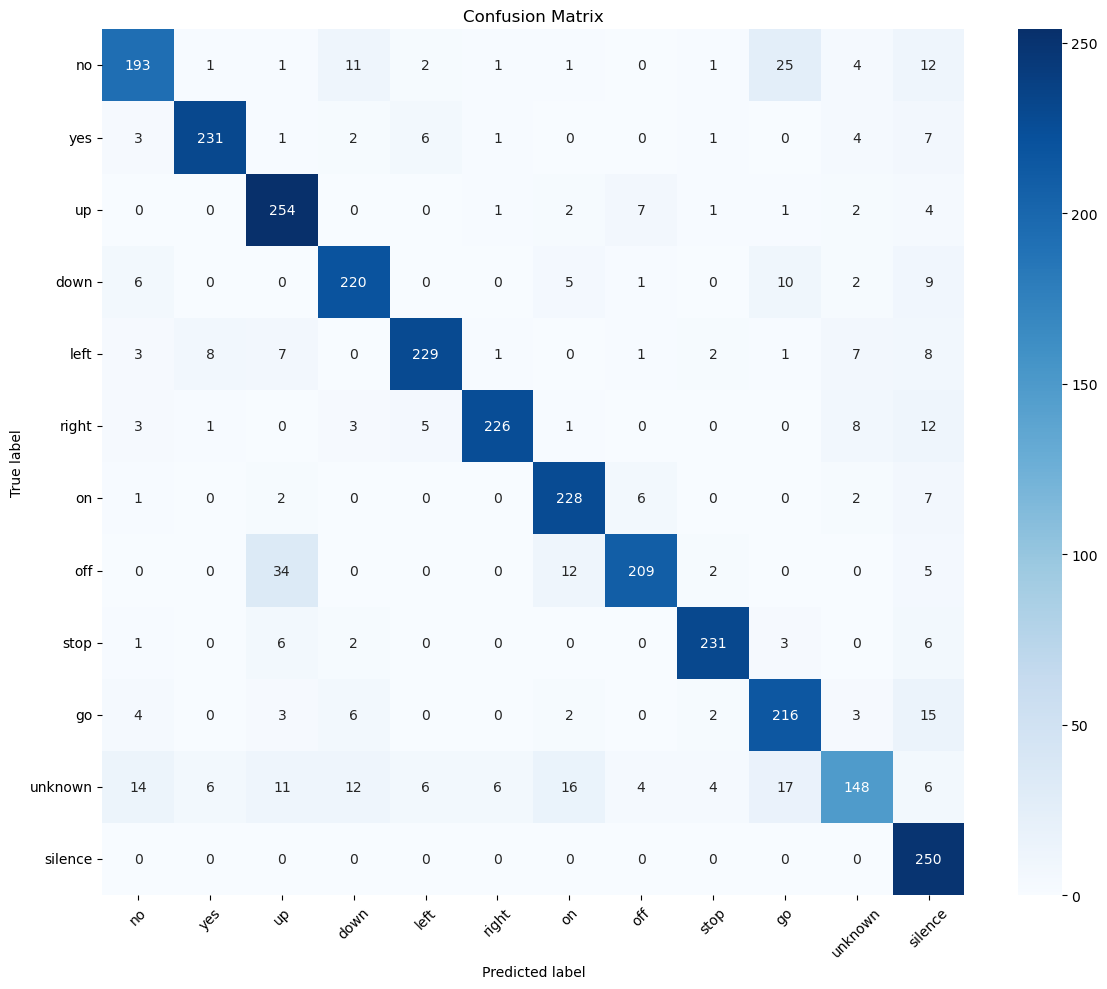

ERROR:asyncio:Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\cypri\anaconda3\envs\Torch_Intro_ML\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\cypri\anaconda3\envs\Torch_Intro_ML\Lib\asyncio\selector_events.py", line 132, in _read_from_self
    data = self._ssock.recv(4096)
           ^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
ERROR:asyncio:Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\cypri\anaconda3\envs\Torch_Intro_ML\Lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\cypri\anaconda3\envs\Torch_Intro_ML\Lib\asyncio\selector_events.py", line

In [ ]:
model_path = "../mlruns/138967053759875846/69e32308c515499fa8c6008aaf834db6/artifacts/checkpoints/model_epoch_14.pth"

import os 
import seaborn as sns
import matplotlib.pyplot as plt


import torch

model = CNNRNNClassifierDropout(
    num_classes=12, input_freq_bins=128
)

model.load_state_dict(torch.load(model_path))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


confusion_matrix = torch.zeros(12, 12)


with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        pred = out.argmax(dim=1)
        for t, p in zip(y.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
class_names = [
    "no", "yes", "up", "down", "left", "right",
    "on", "off", "stop", "go", "unknown", "silence"
]

# Convert to numpy
conf_matrix = confusion_matrix.cpu().numpy()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix, annot=True, fmt='g', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
